# Doc Classification
- This notebook is about doc-classification (classifying whether or not a sub-section is zoning-related)
- Part 1: matching regex zoning code (see if regex pattern appeared in a zoning document)
- Part 2: query methods (a little bit technical, not working too well)
    - 2.1 bm25 score
    - 2.2 keybert for keywords
- Part 3: spacy module (under-construction)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import re
import pickle

# import whapi
# from fuzzywuzzy import fuzz
# from fuzzywuzzy import process

import rank_bm25

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [168]:
def clean_sent(sent):
    '''
    Remove special characters and tokenize the sentence
    '''
    sent = sent.lower()
    # remove special chars
    sent = re.sub("[^0-9a-zA-Z]", " ", sent)
    sent = re.sub(" +", " ", sent)
    
    # remove stop words
    tokens = [w for w in word_tokenize(sent) if w not in stopwords]
    return tokens

def lemmatize(tokens):
    '''
    Lemmatize the tokens in the sentence
    '''
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

def normalize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    arr = np.array(arr)
    arr = (arr - mean) / std
    arr = (arr + 1) / 2
    return arr

In [169]:
def bm25_scores(docs, query):

    # tokenize query
    tokenized_query = lemmatize(clean_sent(query))
    
    # title-based bm25 construction
    corpus_titles = [r['title'] for r in docs]
    tokenized_titles = [lemmatize(clean_sent(doc)) for doc in corpus_titles]
    bm25_title = rank_bm25.BM25Okapi(tokenized_titles)
    scores_title = bm25_title.get_scores(tokenized_query)
    scores_title = normalize(scores_title)
    
    # intro-based bm25 construction
    corpus_content = [r['text'] for r in docs]
    tokenized_content = [lemmatize(clean_sent(doc)) for doc in corpus_content]
    bm25_content = rank_bm25.BM25Okapi(tokenized_content)
    scores_content = bm25_content.get_scores(tokenized_query)
    scores_content = normalize(scores_content)
    
    for i in range(len(docs)):
        docs[i]['scores_content'] = scores_content[i]
        docs[i]['scores_title'] = scores_title[i]
        docs[i]['score'] = scores_content[i] + scores_title[i] #scoring(query_results[i])
    return docs

In [170]:
%run ../src/tree_spider.py
%run ../src/utils.py

# 1. Zoning district - regex matching

In [99]:
# md_zoning_codes.zoning.values

In [60]:
import string
string_printable_set = set(list(string.printable))

In [61]:
def find_zoning_district_code(all_text):
    all_keys = {}
    key_2_text = {}
    all_match = list(re.finditer('[A-Z] *-[0-9]', all_text))
    
    for match in all_match:
        key = match.group()
        if key not in all_keys.keys():
            all_keys[key] = 1
        else:
            all_keys[key] += 1
    
    less_than_2 = 0
    text_around_dict = {}
    for match in all_match:
        span = match.span()
        key = match.group()
        if all_keys[key] < 2:
            less_than_2 += 1
            continue
        text_around = all_text[max(0, span[0] - 30): min(span[1] + 30, len(all_text))]
        text_around = text_around.lower()
        text_around = ''.join([c for c in text_around if c in string_printable_set])
        text_around = re.sub('\n', ' ', text_around)
        text_around = re.sub('\t', ' ', text_around)
        text_around = re.sub(' +', ' ', text_around).strip()
        if key in text_around_dict.keys():
            text_around_dict[key].append(text_around)
        else:
            text_around_dict[key] = [text_around]
    #tmp_keys, key_counts = np.unique(all_keys, return_counts = True)
    for key in key_2_text.keys():
        text, text_counts = np.unique(key_2_text[key], return_counts = True)
        key_2_text[key] = list(zip(text, text_counts))
    all_keys, key_count = list(all_keys.keys()), list(all_keys.values())
    result = ({
        'idx': i,
        'keys_lst': list(zip(all_keys, key_count)),
        # 'keys_texts': key_2_text,
        'text_around_dict': text_around_dict,
        'keys_count': len(all_keys),
        'more_than_2_counts': sum(np.array(key_count) >= 2)
    })
    return result

In [70]:
# s = 'hi, i am R-1, hi, F-2,syo J-0'
# for i in re.finditer('[A-Z] *-[0-9]', s):
#     print(i)
#     print(i.span())
#     print(i.group())

In [76]:
zoning_code = []
for i in tqdm(range(100)):
    ts = pickle.load(open('../data/scrapped/pickles_ts/' + str(i) + '.pkl', 'rb'))
    all_leaf_doc = []
    city_name = all_meta_data['City/County'].values[i]
    def find_leaf(node):
        if node.is_leaf:
            all_leaf_doc.append({
                'title': node.title,
                'text': node.text_content
            } )
        else:
            for child in node.children:
                find_leaf(child)
    find_leaf(ts.root_node)
    if len(all_leaf_doc) == 0:
        print('no leaf on:', i)
        continue
    
    all_text = '\n'.join([doc['text'] for doc in all_leaf_doc])
    result = find_zoning_district_code(all_text)
    result['city'] = city_name
    zoning_code.append(result)

 77%|████████████████████████▋       | 77/100 [00:00<00:00, 86.53it/s]

no leaf on: 67


100%|███████████████████████████████| 100/100 [00:01<00:00, 77.80it/s]


In [77]:
# all_text

In [78]:
zoning_code_df = pd.DataFrame(zoning_code)
zoning_code_df.head(10)

,idx,keys_lst,text_around_dict,keys_count,more_than_2_counts,city
0,0,"[(B-2, 26), (C-1, 1), (M-1, 18), (R-1, 54), (R...","{'B-2': ['ach apartment number, such as b-210....",21,11,Alabaster
1,1,"[(I-1, 1), (W-2, 9), (A-1, 3), (A-2, 4), (A-3,...",{'W-2': ['ederal income tax returns and w-2 fo...,23,16,Albertville
2,2,"[(U-1, 25), (U-9, 7), (B-6, 1), (I-3, 3), (A-9...","{'U-1': ['aces. [[content]] [4, ord. u-1151-16...",7,5,Alexander City
3,3,"[(L-1, 1), (B-1, 3), (W-2, 1), (F-2, 1), (R-2,...",{'B-1': ['on county surveyor's map no. b-1864 ...,23,9,Aliceville
4,4,"[(C-2, 27), (C-3, 16), (M-1, 17), (M-2, 15), (...",{'C-2': ['s within the central trading (c-2) d...,10,8,Andalusia
5,5,"[(A-1, 10), (A-2, 3), (A-3, 3), (A-4, 4), (A-5...","{'A-1': ['re footage assembly group a - a-1, a...",33,17,Anniston
6,6,"[(T-2, 2), (A-2, 3), (L-1, 1)]",{'T-2': ['urvey of the site. (must meet t-2 ac...,3,2,Arab
7,7,"[(L-1, 1)]",{},1,0,Athens
8,8,"[(L-1, 2)]","{'L-1': ['ead, federal specification qq-l-156,...",1,1,Atmore
9,9,"[(M-2, 1), (L-1, 1), (A-2, 1)]",{},3,0,Auburn


/opt/anaconda3/envs/dsml/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

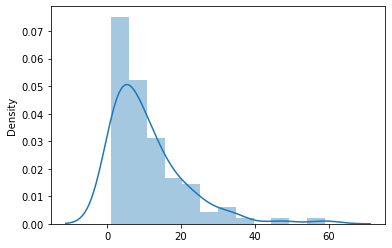

In [79]:
sns.distplot(zoning_code_df.keys_count.values)

/opt/anaconda3/envs/dsml/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

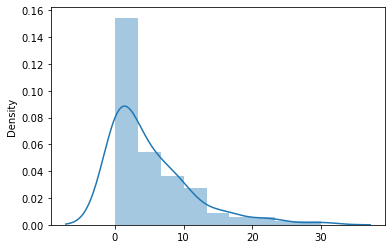

In [80]:
sns.distplot(zoning_code_df.more_than_2_counts.values)

In [81]:
# all_text = '\n'.join([doc['text'] for doc in all_leaf_doc])
# np.unique(re.findall('[A-Z] *-[0-9]', all_text))

In [82]:
zoning_code_df.to_csv('../data/zoning_code_df.csv', index = False)

In [186]:
zoning_code_df.query('keys_count < 5').shape

(32, 6)

In [188]:
zoning_code_df.query('more_than_2_counts < 5').shape

(58, 6)

# 2. Query Methods
## 2.1 bm25 query

In [101]:
md_zoning_codes = pd.read_csv('../data/md_zoning_codes.csv')
md_zoning_codes.head()

,jurscode,county,muni,premcity,zoneauth,zoning,zoning_name
0,KENT,Kent,Kent,KENT,COUNTY,AZD,Agricultural
1,MONT,Montgomery,Laytonsville,LAYTONSVILLE,MUNICIPALITY,A,Agricultural
2,TALB,Talbot,Trappe,TRAPPE,MUNICIPALITY,A,Agricultural
3,WICO,Wicomico,Wicomico,WICOMICO,COUNTY,A-1,Agricultural - Rural
4,HARF,Harford,Harford,HARFORD,COUNTY,AG,Agricultural (Conventional Residential)


In [197]:
md_zoning_codes.zoning.unique()

array(['AZD', 'A', 'A-1\xa0', 'AG', 'A (R )', 'AC', 'AC-RCA', 'A-1',
       'A-2', 'AR', 'AT', 'A-R', 'R-3', 'A.S.', 'NC-20', 'BSC', 'CBA',
       'CR', 'CBT', 'CC', 'CMPD', 'CC-MU', 'C-1', 'C', 'C3', 'C1', 'CM',
       'C-M ', 'C2', 'CR0.5', 'CR0.7', 'CR1.0', 'CR1.2', 'CR1.5', 'CR1.7',
       'CR2.0', 'CR2.2', 'CR2.5', 'CR2.7', 'CR3.0', 'CR3.5', 'CR4.0',
       'CR5.0', 'CR5.2', 'CR6.0', 'CR6.2', 'CR7.2', 'CR8.0', 'CRN1.0',
       'CRN0.2', 'CRN0.7', 'CRT0.2', 'CRT0.7', 'CRT1.0', 'CRT1.2',
       'CRT1.7', 'CRT2.0', 'CRT2.2', 'CRT3.0', 'CRT4.0', 'C.C.C', 'C.R.',
       'C.T', 'CRN', 'CRT', 'C-2', 'L-A-C', 'M-A-C', 'R-L', 'R-M', 'R-S',
       'R-U', 'V-L', 'V-M', 'B1', 'CER', 'CMR', 'CRR', 'CMX', 'CAC', 'CD',
       'CMU', 'CP', 'CAR', 'D.R.1', 'D.R.10.5', 'D.R.16', 'D.R.2',
       'D.R.3.5', 'D.R.5.5', 'R-2', 'R-4', 'R-1A', 'R-1B', 'R-1C', 'R-1D',
       'R-1E', 'R-1', 'DB', 'DMX', 'C-5', 'DBO', 'DR', 'R-5', 'O-EOD',
       'EC', 'EMU', 'EC ', 'R.C.8', 'O-HIS', 'E', 'E-1', 'FFD', 'C-3

In [193]:
zoning_names_all_text = '\n'.join(list(md_zoning_codes.zoning_name.unique()))
zoning_names_all_text = lemmatize(clean_sent(zoning_names_all_text))

In [194]:
tokens, counts = np.unique(zoning_names_all_text, return_counts = True)
token_2_count = dict(zip(tokens, counts / sum(counts)))

In [195]:
tokens

array(['0', '000', '1', '10', '150', '15000', '16', '2', '200', '20000',
       '21', '217800', '25', '3', '4', '40', '400', '43560', '5', '60',
       '75', '8', '80', '8000', '87120', '90', 'acre', 'activity',
       'agricultural', 'agriculture', 'apartment', 'area', 'attached',
       'automotive', 'avg', 'bio', 'buffer', 'building', 'business',
       'campus', 'care', 'center', 'central', 'character', 'chester',
       'city', 'class', 'cluster', 'cmu', 'co', 'commercial', 'common',
       'community', 'comprehensive', 'condominium', 'conservation',
       'continuing', 'convenience', 'conventional', 'conversion',
       'copmmercial', 'core', 'coridor', 'corridor', 'countryside',
       'critical', 'data', 'deferral', 'density', 'design', 'detached',
       'development', 'deveopment', 'district', 'downtown', 'dunkirk',
       'dwelling', 'east', 'educational', 'efficiency', 'elderly',
       'elevator', 'employment', 'enhancement', 'entertainment',
       'environmental', 'eode

In [111]:
# token_2_count

In [146]:
ts = pickle.load(open('../data/scrapped/pickles_ts/1.pkl', 'rb'))

In [147]:
all_meta_data = pd.read_csv('../data/ordinates_meta_data.csv', sep = '*')
all_meta_data_ecode_360 = all_meta_data.query('Site == "General Code"').reset_index(drop = True)
all_meta_data_ecode_360['href'] = all_meta_data_ecode_360.Ordinance.apply(lambda x: x.split('/')[-1]).values
all_meta_data_ecode_360['unique_id'] = range(all_meta_data_ecode_360.shape[0])
# all_meta_data_ecode_360.head(2)
meta_data = all_meta_data_ecode_360

In [148]:
meta_data.iloc[1]

State                               California
City/County    City of Albany (Alameda County)
Ordinance          https://ecode360.com/AL4074
Site                              General Code
href                                    AL4074
unique_id                                    1
Name: 1, dtype: object

In [149]:
all_leaf_doc = ts.find_all_leaf_text()

len(all_leaf_doc)

29

In [151]:
# query = 'zoning district, residential, minimum lot size, maximum density, minimum lot area'
query = ', '.join(tokens[1:])
query

'agricultural, agriculture, apartment, area, automotive, avg, bio, business, campus, center, central, chester, city, commercial, conservation, conventional, development, district, general, local, lot, marine, master, mixed, neighborhood, office, planned, reserved, residential, resource, rural, science, service, size, transition, use, zone, zoning'

In [136]:
# keywords = open('../data/keywords.txt', 'r').readlines()
# keywords = [k.strip().lower() for k in keywords]
# query = ' '.join(keywords)
# query

In [137]:
all_leaf_doc = bm25_scores(all_leaf_doc, query)

In [138]:
all_leaf_doc = sorted(all_leaf_doc, key = lambda doc: doc['score'], reverse = True)

In [140]:
# [doc['title'] for doc in all_leaf_doc]

In [130]:
# all_leaf_doc

In [68]:
# [doc['title'] for doc in all_leaf_doc]

## 2.2. keybert

In [82]:
%run ../src/utils.py

glove_dict = load_glove_embeddings()

100%|██████████████████████| 400000/400000 [00:32<00:00, 12159.23it/s]


In [69]:
from keybert import KeyBERT

kw_model = KeyBERT()

In [86]:
len(glove_dict['zoning'])

300

In [91]:
keywords = open('../data/keywords.txt', 'r').readlines()
keywords = [clean_sent(k.strip().lower()) for k in keywords[:5]]
# keywords_vec = [np.mean()]

[['lot', 'area'],
 ['lot', 'size'],
 ['building', 'area'],
 ['building', 'site', 'area', 'acres', 'dwelling', 'unit'],
 ['square', 'feet', 'dwelling', 'unit']]

In [96]:
query_vec = [] 
for k in keywords:
    vec = np.zeros(300)
    for w in k:
        vec += np.array(glove_dict[w])
    vec /= len(k)
    query_vec.append(list(vec))
query_vec = np.array(query_vec)
query_vec.shape

(5, 300)

In [128]:
from numpy.linalg import norm

def cos_sim(v1, v2):
    if sum(v1 == 0) == len(v1) or sum(v2 == 0) == len(v2):
        return 0
    result = np.dot(v1, v2)/(norm(v1)*norm(v2))
    return result

def calc_sim_scores(query_vec, keywords_vec):
    sim_scores = np.array([[cos_sim(k, q) for k in keywords_vec] for q in query_vec])
    max_scores = sim_scores.max(axis = 1)
    avg_max = max_scores.mean()
    return avg_max

def softmax(vec):
    sum_of_exp = sum([np.exp(i) for i in vec])
    vec = [np.exp(i) / sum_of_exp for i in vec]
    return np.array(vec)

In [159]:
for doc in tqdm(all_leaf_doc):
    content = doc['text']
    keywords = kw_model.extract_keywords(content, keyphrase_ngram_range=(1, 1), stop_words='english', top_n=20)
    keywords_scores = softmax([k[1] for k in keywords])
    keywords = [k[0] for k in keywords]
    keywords_vec = []
    for i in range(len(keywords)):
        w = keywords[i]
        vec = np.zeros(300)
        valid_count = 0
        for token in w.split():
            if token in glove_dict.keys():
                vec += np.array(glove_dict[token])
                valid_count += 1
        if valid_count > 0:
            vec /= valid_count
        keywords_vec.append(vec)
    
    sim_scores = np.array([[cos_sim(k, q) for k in keywords_vec] for q in query_vec])
    sim_scores = sim_scores * keywords_scores
    max_scores = sim_scores.max(axis = 1)
    glove_sim_score = max_scores.mean()
    #print(max_scores, keywords_scores)
    #break
    #glove_sim_score = calc_sim_scores(query_vec, keywords_vec)
    doc['glove_sim_score'] = glove_sim_score
    doc['keywords'] = keywords

100%|███████████████████████████████| 185/185 [01:37<00:00,  1.90it/s]


In [ ]:
all_leaf_doc = sorted(all_leaf_doc, key = lambda doc: doc['glove_sim_score'], reverse = True)

In [131]:
# a = np.array([[1, 2, 3],
#               [2, 1, 5]])
# b = np.array([0.1, 0.3, 0.6])
# a * b

In [160]:
all_bm25_scores = [doc['score'] for doc in all_leaf_doc]
bm25_mean = np.mean(all_bm25_scores)
bm25_std = np.std(all_bm25_scores)

all_glove_scores = [doc['glove_sim_score'] for doc in all_leaf_doc]
glove_mean = np.mean(all_glove_scores)
glove_std = np.std(all_glove_scores)

bm25_mean, bm25_std, glove_mean, glove_std

(29.684743784360467,
 22.724068402951694,
 0.034873400722344405,
 0.03099082789110115)

In [162]:
for doc in all_leaf_doc:
    if '(Reserved)' in doc['title']:
        doc['normalized_scores'] = 0
        continue
    g = (doc['glove_sim_score'] - glove_mean) / glove_std
    g = (g + 1) / 2
    b = (doc['score'] - bm25_mean) / bm25_std
    b = (b + 1) / 2
    doc['normalized_scores'] = (g + b) / 2 / np.log(len(doc['text']))

In [173]:
all_leaf_doc = sorted(all_leaf_doc, key = lambda doc: doc['normalized_scores'], reverse = True)

In [174]:
median_score = np.median([doc['normalized_scores'] for doc in all_leaf_doc])
median_score

0.045608003711205505

In [175]:
# all_leaf_doc[0]

In [176]:
# [doc['keywords'] for doc in all_leaf_doc]

In [178]:
# [(doc['title'], len(doc['text']), doc['normalized_scores'], doc['glove_sim_score'], doc['score']) for doc in all_leaf_doc]

In [179]:
from transformers import pipeline
question_answering = pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


In [180]:
for doc in tqdm(all_leaf_doc):
    if doc['normalized_scores'] < median_score:
        answer = ''
        answer_score = 0
    else:
        question = "What is the minimun lot area requirement?"
        context = doc['text']
        result = question_answering(question=question, context=context)
        answer = result['answer']
        answer_score = result['score']
    doc['answer'] = answer
    doc['answer_score'] = answer_score

  0%|                                         | 0/185 [00:00<?, ?it/s]/opt/anaconda3/envs/dsml/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/opt/anaconda3/envs/dsml/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = np.asarray(
100%|███████████████████████████████| 185/185 [04:47<00:00,  1.55s/it]


In [187]:
len(all_leaf_doc)

185

In [185]:
[(doc['title'], doc['normalized_scores'], doc['answer'], doc['answer_score']) for doc in all_leaf_doc]

[('DIVISION 4.10\t    \tAccessory Buildings; Accessory Dwelling Units',
  0.1784120205338145,
  'Site plan drawn to scale',
  0.22192487120628357),
 ('DIVISION 4.9\t    \tYard, Size and Area Requirements',
  0.13838447499442375,
  'No buildings shall be erected or enlarged',
  0.007866079919040203),
 ('DIVISION 6.7\t    \tLot Split Requirements',
  0.13526418905102658,
  'A completed application with required signatures',
  0.07060255110263824),
 ('DIVISION 6.6\t    \tLarge-Lot Split Requirements',
  0.12024219474534982,
  'All resulting lots\nmust be 10 acres or greater',
  0.1510065197944641),
 ('DIVISION 4.16\t    \tOff-Street Parking and Loading',
  0.12015838781046127,
  'child-care centers, day-care family\nhomes, residential home day cares',
  0.12157001346349716),
 ('DIVISION 4.2\t    \tAgricultural District Regulations',
  0.11331899147407022,
  'Yard, size',
  0.008044905960559845),
 ('DIVISION 2.6\t    \tFees',
  0.11195827307337715,
  'splits',
  0.045381177216768265),
 ('D

## 2.3 Deploy on the whole dataset

In [171]:
all_meta_data = pd.read_csv('../data/ordinates_meta_data.csv', sep = '*')
all_meta_data_ecode_360 = all_meta_data.query('Site == "General Code"').reset_index(drop = True)
all_meta_data_ecode_360['href'] = all_meta_data_ecode_360.Ordinance.apply(lambda x: x.split('/')[-1]).values
all_meta_data_ecode_360['unique_id'] = range(all_meta_data_ecode_360.shape[0])
# all_meta_data_ecode_360.head(2)
meta_data = all_meta_data_ecode_360
meta_data.head(2)

,State,City/County,Ordinance,Site,href,unique_id
0,Arkansas,City of Lincoln (Washington County),https://ecode360.com/LI3811,General Code,LI3811,0
1,California,City of Albany (Alameda County),https://ecode360.com/AL4074,General Code,AL4074,1


In [172]:
all_doc_results = []
for i in tqdm(range(100)):
    curr_row = meta_data.iloc[i]
    ts = pickle.load(open('../data/scrapped/pickles_ts/' + str(i) + '.pkl', 'rb'))
    
    all_leaf_doc = ts.find_all_leaf_text()
    if len(all_leaf_doc) == 0:
        top_three_titles = []
    else:
        all_leaf_doc = bm25_scores(all_leaf_doc, query)
        all_leaf_doc = sorted(all_leaf_doc, key = lambda doc: doc['score'], reverse = True)
        top_three_titles = [doc['title'] for doc in all_leaf_doc[:3]]
    all_doc_results.append({
        'idx': i,
        'city': curr_row['City/County'],
        'top_three_titles': top_three_titles
    })

100%|███████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


In [173]:
all_doc_results_df = pd.DataFrame(all_doc_results)

In [174]:
all_doc_results_df

,idx,city,top_three_titles
0,0,City of Lincoln (Washington County),[DIVISION 4.4 Commercial Mixed-Use Distri...
1,1,City of Albany (Alameda County),"[Chapter 20 Planning and Zoning, Chapter ..."
2,2,City of Avalon (Los Angeles County),[Chapter 5-20 Medical Cannabis Delivery S...
3,3,City of Compton (Los Angeles County),"[Chapter 30 Zoning, Chapter 9 Genera..."
4,4,City of Firebaugh (Fresno County),"[Chapter 25 Zoning, Chapter 4 Licens..."
...,...,...,...
95,95,Town of Selbyville (Sussex County),[Article XII GC General Commercial Distri...
96,96,Town of South Bethany (Sussex County),"[Article IX C-1 Commercial District, Arti..."
97,97,Sussex County (Sussex County),[Article XID C-4 Planned Commercial Distr...
98,98,City of South Pasadena (Pinellas County),"[Article III Zoning Districts, Article I ..."


In [175]:
all_doc_results_df.iloc[0].top_three_titles

['DIVISION 4.4      Commercial Mixed-Use District Regulations',
 'DIVISION 4.7      Planned Unit Development (PUD)',
 'DIVISION 4.2      Agricultural District Regulations']

In [176]:
all_doc_results_df['top_1'] = [t[0] if len(t) > 0 else [] for t in all_doc_results_df.top_three_titles.values]
all_doc_results_df['top_2'] = [t[1] if len(t) > 0 else [] for t in all_doc_results_df.top_three_titles.values]
all_doc_results_df['top_3'] = [t[2] if len(t) > 0 else [] for t in all_doc_results_df.top_three_titles.values]

In [177]:
all_doc_results_df.to_csv('../data/all_doc_results_df.csv', index = False)

In [166]:
# all_leaf_doc

In [179]:
all_doc_results_df = pd.read_csv('../data/all_doc_results_df.csv')
# all_doc_results_df

In [180]:
all_doc_results_df.query('correctness == 1').shape

(31, 6)

In [181]:
all_doc_results_df.query('correctness == 2').shape

(23, 6)

In [182]:
all_doc_results_df.query('correctness == 3').shape

(46, 6)

# 3. Spacy

In [93]:
ts = pickle.load(open('../data/scrapped/pickles_ts/1.pkl', 'rb'))

In [95]:
all_leaf_doc = []

def find_leaf(node):
    if node.is_leaf:
        all_leaf_doc.append({
            'title': node.title,
            'text': node.text_content
        } )
    else:
        for child in node.children:
            find_leaf(child)

find_leaf(ts.root_node)
all_leaf_text = 
len(all_leaf_doc)

29

In [97]:
# all_leaf_doc

In [92]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [100]:
doc = nlp("This is a sentence.")
print([(w.text, w.pos_) for w in doc])

[('This', 'PRON'), ('is', 'AUX'), ('a', 'DET'), ('sentence', 'NOUN'), ('.', 'PUNCT')]


In [183]:
context = '''
Four zoning districts are provided for residential development. Of these, three districts are provided for single family residential development, while one district is provided for both single and multiple family residential developments.
   The single family districts provide for a limited range of housing densities consistent with the Village's established residential neighborhoods. The R-A District allows for lower density residential use and larger lot sizes. The R-B and R-C Districts allow for somewhat higher density residential use and smaller lot sizes.
   The R-D District permits single family residential developments and permits as a special use higher density residentialbuilding types consistent with existing development patterns. (Amended 6/2003)
   The single family district regulations are intended to preserve established neighborhoods and encourage new residential development consistent with the overall character of the Village. The multiple family district regulations are designed to encourage a moderate density residential area including alternate housing types in a suburban residential environment.
'''

In [184]:
doc = nlp(context)
print([(w.text, w.pos_) for w in doc])

[('\n', 'SPACE'), ('Four', 'NUM'), ('zoning', 'VERB'), ('districts', 'NOUN'), ('are', 'AUX'), ('provided', 'VERB'), ('for', 'ADP'), ('residential', 'ADJ'), ('development', 'NOUN'), ('.', 'PUNCT'), ('Of', 'ADP'), ('these', 'PRON'), (',', 'PUNCT'), ('three', 'NUM'), ('districts', 'NOUN'), ('are', 'AUX'), ('provided', 'VERB'), ('for', 'ADP'), ('single', 'ADJ'), ('family', 'NOUN'), ('residential', 'ADJ'), ('development', 'NOUN'), (',', 'PUNCT'), ('while', 'SCONJ'), ('one', 'NUM'), ('district', 'NOUN'), ('is', 'AUX'), ('provided', 'VERB'), ('for', 'ADP'), ('both', 'CCONJ'), ('single', 'ADJ'), ('and', 'CCONJ'), ('multiple', 'ADJ'), ('family', 'NOUN'), ('residential', 'ADJ'), ('developments', 'NOUN'), ('.', 'PUNCT'), ('\n   ', 'SPACE'), ('The', 'DET'), ('single', 'ADJ'), ('family', 'NOUN'), ('districts', 'NOUN'), ('provide', 'VERB'), ('for', 'ADP'), ('a', 'DET'), ('limited', 'ADJ'), ('range', 'NOUN'), ('of', 'ADP'), ('housing', 'NOUN'), ('densities', 'NOUN'), ('consistent', 'ADJ'), ('with', '